In [1]:
import cdsapi
import xarray

In [2]:
bodensee_area = [48.00, 8.54, 47.29, 10.17] # Bodensee
europe_area= [60., -11., 34., 35.] # Europe

In [3]:
import hashlib
import os

cds_data_dir = "data/cds"
temp_dir = "data/temp"

class CDS_Dataset():
    def __init__(self, topic, config):
        self.topic = topic
        self.config = config

    def path(self):
        h = hashlib.new('SHA256')
        h.update(self.topic.encode('utf-8'))
        for k, v in sorted(self.config.items()):
            h.update(f'|{k}:{v}'.encode('utf-8'))
        fingerprint = h.hexdigest()[:16]
        return f"{cds_data_dir}/dataset_{fingerprint}.{self.config["format"]}"
        

    def retrieve(self):
        os.makedirs(cds_data_dir, exist_ok=True)
        cdsc = cdsapi.Client()
        cdsc.retrieve(self.topic, self.config, self.path())

    def is_local(self):
        return os.path.exists(self.path())

    def load(self):
        if not self.is_local():
            self.retrieve()

        return self.path()

dataset = CDS_Dataset(
    'satellite-lake-water-temperature', {
        'variable': 'all',
        'format': 'zip',
        'version': '4.5.2',
        'year': '2022',
        'month': [ f"{x:02d}" for x in range(1, 13) ],
        'day': [ f"{x:02d}" for x in range(1, 32) ],
        'area': europe_area
    })

dataset.load()

'data/cds/dataset_8354edaf83c1de16.zip'

In [4]:
# Lake Water Surface Temperature
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-lake-water-temperature

import logging
import shutil
import tempfile
import zipfile

class SatelliteLakeWaterTemperature():
    def __init__(self, area, years):
        self.topic = 'satellite-lake-water-temperature'
        self.area = area
        self.years = years
        self.nc_dir = None

    def cds_dataset_year(self, year):
        config = dict(
            variable = 'all',
            format = 'zip',
            version = '4.5.1' if year <= 2020 else '4.5.2',
            year = year,
            month = [ f"{x:02d}" for x in range(1, 13) ],
            day = [ f"{x:02d}" for x in range(1, 32) ],
            area = self.area,
        )
        return CDS_Dataset(self.topic, config)

    def load(self):
        datasets = [ self.cds_dataset_year(y) for y in self.years ]
        local = sum([d.is_local() for d in datasets])
        print(f"{local}/{len(datasets)} datasets are available locally")
        if local < len(datasets):
            print("get remaining datasets from CDS ...")
        return [ d.load() for d in datasets ]

    def xarray(self):
        if self.nc_dir is None:
            self.nc_dir = tempfile.mkdtemp(prefix="cds-" + self.topic + "-")
            
            for path in self.load():  
                with zipfile.ZipFile(path,"r") as f:
                    f.extractall(self.nc_dir)

        nc_files = [ e.path for e in os.scandir(self.nc_dir) if e.path.endswith(".nc") ]
        nc_files = sorted(nc_files)
        return xarray.open_mfdataset(nc_files)

    def free(self):
        if self.nc_dir is not None:
            shutil.rmtree(self.nc_dir)
        

    def __del__(self):
        # self.free()
        pass

d = SatelliteLakeWaterTemperature(europe_area, years = [2021, 2022]).xarray()
d

2/2 are available locally


<xarray.Dataset> Size: 13GB
Dimensions:                         (time: 730, lat: 520, lon: 920)
Coordinates:
  * lat                             (lat) float32 2kB 34.03 34.08 ... 59.97
  * lon                             (lon) float32 4kB -10.98 -10.93 ... 34.97
  * time                            (time) datetime64[ns] 6kB 2021-01-01T12:0...
Data variables:
    lake_surface_water_temperature  (time, lat, lon) float32 1GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lswt_uncertainty                (time, lat, lon) float32 1GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lswt_quality_level              (time, lat, lon) float32 1GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lswt_obs_instr                  (time, lat, lon) float32 1GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lswt_flag_bias_correction       (time, lat, lon) float32 1GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lakeid_CCI                      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
    lakeid_GloboLakes               (time, lat, lon) float64 3GB dask.array<chunksize=(1, 520, 920), meta=np.ndarray>
Attributes: (12/51)
    title:                           UK Earth Observation Climate Information...
    institution:                     EOCIS, University of Reading
    summary:                         L3S product from the ESA CCI project: LS...
    citation:                        Carrea, L., Crétaux, J.-F., Liu, X., Wu,...
    licence:                         Creative Commons Attribution 4.0 Interna...
    reference:                       https://cds.climate.copernicus.eu
    ...                              ...
    easternmost_longitude:           180.0
    westernmost_longitude:           -180.0
    processing_level:                L3S
    cdm_data_type:                   grid
    source_file:                     20210101120000-ESACCI-L3C_GHRSST-SLSTRA-...
    source_file_path:                /gws/nopw/j04/nceo_uor/users/lcarrea01/O...

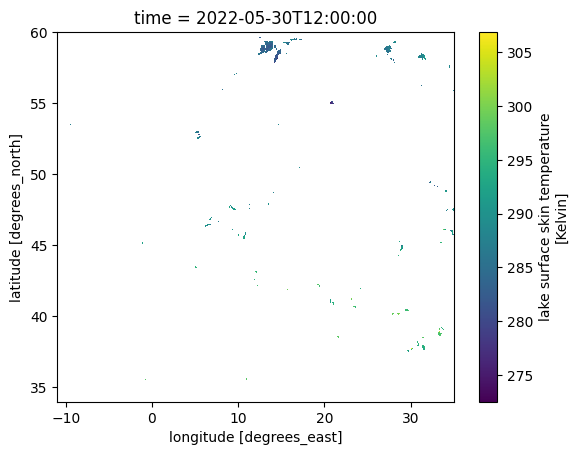

In [5]:
d.sel(time='2022-05-30T12:00')['lake_surface_water_temperature'].plot()

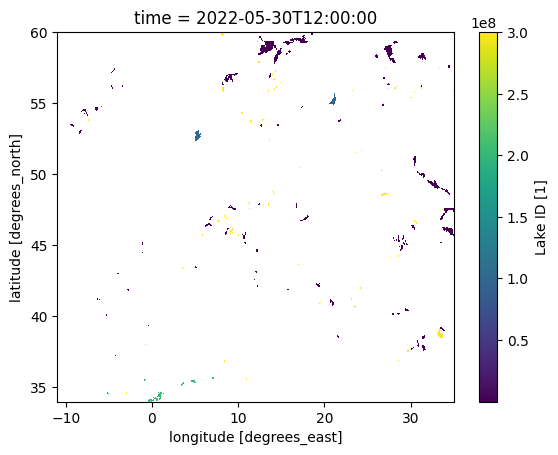

In [6]:
d.sel(time='2022-05-30T12:00')['lakeid_CCI'].plot()

In [8]:
# CCI lake ids
# Dataset: https://zenodo.org/records/6699376
# CSV Download: https://zenodo.org/records/6699376/files/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021.csv?download=1
import pandas
pandas.read_csv("data/esa-cci-lakes.csv").set_index('CCI ID').loc[352]

NAME                              Constance lake/Bodensee
COUNTRY                       Austria;Switzerland;Germany
MAX DISTANCE TO LAND (KM)                             6.0
LAT CENTRE                                        47.5431
LON CENTRE                                         9.5097
LAT MIN BOX                                       47.4375
LAT MAX BOX                                       47.8542
LON MIN BOX                                        8.7958
LON MAX BOX                                        9.7875
ID in GLOBOLAKES 1000 MASK                           352;
ID in CGLOPS MASK                                    352;
Name: 352, dtype: object